In [5]:
import numpy as np
import pandas as pd

from tensorflow import one_hot
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import text, sequence

import re
import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [92]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 10000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 100

EMBEDDING_DIM=100

In [127]:
train=pd.read_csv("./jigsaw-toxic-comment-classification-challenge/train.csv.zip")

In [128]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].to_numpy()

In [96]:
#nltk.download('stopwords')

In [129]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;\n]')
BAD_SYMBOLS_RE = re.compile('[^a-z ]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
train['comment_text'] = train['comment_text'].apply(clean_text)

In [130]:
tokenizer = text.Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(train["comment_text"].values)

In [131]:
X = tokenizer.texts_to_sequences(train["comment_text"].values)
X = sequence.pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

In [132]:
del train

In [101]:
del y

In [102]:
def word2vec (x,X,Y,width=2):
    for i in range(MAX_SEQUENCE_LENGTH):
        if i<width:
            for j in range(1,width+1):
                new_x=x[i]
                new_y=x[i+j]
                if new_x and new_y:
                    X.append(new_x)
                    Y.append(new_y)
            for j in range(-1,-(width+1),-1):
                if (j+i)<0:
                    break
                new_x=x[i]
                new_y=x[i+j]
                if new_x and new_y:
                    X.append(new_x)
                    Y.append(new_y)
        elif i>(MAX_SEQUENCE_LENGTH-1-width):
            for j in range(1,width+1):
                if (j+i)>(MAX_SEQUENCE_LENGTH-1):
                    break
                new_x=x[i]
                new_y=x[i+j]
                if new_x and new_y:
                    X.append(new_x)
                    Y.append(new_y)
            for j in range(-1,-(width+1),-1):
                new_x=x[i]
                new_y=x[i+j]
                if new_x and new_y:
                    X.append(new_x)
                    Y.append(new_y)
        else:
            for j in range(1,width+1):
                new_x=x[i]
                new_y=x[i+j]
                if new_x and new_y:
                    X.append(new_x)
                    Y.append(new_y)
            for j in range(-1,-(width+1),-1):
                new_x=x[i]
                new_y=x[i+j]
                if new_x and new_y:
                    X.append(new_x)
                    Y.append(new_y)
    return 0     

In [103]:
w2vX=[]
w2vY=[]
for i in X:
    word2vec(i,w2vX,w2vY,2)

In [104]:
del X

In [105]:
w2vX=np.array(w2vX)
w2vY=np.array(w2vY)

In [106]:
w2vX=np.reshape(w2vX,(w2vX.shape[0],1))

In [107]:
model = keras.Sequential()
model.add(layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=1,mask_zero=True))
model.add(layers.Dense(MAX_NB_WORDS,activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',optimizer='adam')

epochs = 5
batch_size = 64

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 1, 100)            1000000   
_________________________________________________________________
dense_7 (Dense)              (None, 1, 10000)          1010000   
Total params: 2,010,000
Trainable params: 2,010,000
Non-trainable params: 0
_________________________________________________________________


In [108]:
history = model.fit(w2vX,w2vY, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
13870/13870 [==============================] - 149s 11ms/step - loss: 8.0852 - val_loss: 7.8048
Epoch 2/5
13870/13870 [==============================] - 143s 10ms/step - loss: 7.4897 - val_loss: 7.7483
Epoch 3/5
13870/13870 [==============================] - 144s 10ms/step - loss: 7.1879 - val_loss: 7.7804
Epoch 4/5
13870/13870 [==============================] - 147s 11ms/step - loss: 6.9476 - val_loss: 7.8509
Epoch 5/5
13870/13870 [==============================] - 148s 11ms/step - loss: 6.7746 - val_loss: 7.9327


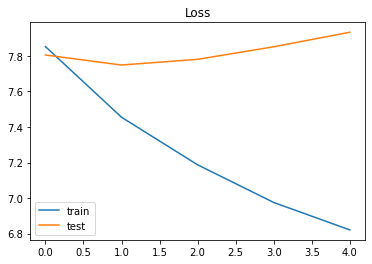

In [109]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [114]:
model.predict(np.array([6]))[0,0,:]

array([5.1833648e-09, 7.5112218e-03, 1.0368161e-02, ..., 2.5925651e-06,
       1.4145742e-05, 8.9281875e-06], dtype=float32)

In [115]:
model.save_weights("mamodel")

In [118]:
model.layers[0]

In [146]:
rnn_model = keras.Sequential()
rnn_model.add(model.layers[0])
rnn_model.add(layers.Dropout(0.3))
rnn_model.add(layers.LSTM(50, dropout=0.2, recurrent_dropout=0.2))
rnn_model.add(layers.Dense(6, activation='sigmoid'))
rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['BinaryAccuracy'])

epochs = 2
batch_size = 20

In [147]:
model.layers[0].trainable = False

In [148]:
rnn_model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 1, 100)            1000000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 100)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 306       
Total params: 1,030,506
Trainable params: 30,506
Non-trainable params: 1,000,000
_________________________________________________________________


In [149]:
history = rnn_model.fit(X, y, epochs=2, batch_size=batch_size,validation_split=0.1,callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/2
7181/7181 [==============================] - 637s 88ms/step - loss: 0.0642 - binary_accuracy: 0.9785 - val_loss: 0.0514 - val_binary_accuracy: 0.9814
Epoch 2/2
7181/7181 [==============================] - 616s 86ms/step - loss: 0.0441 - binary_accuracy: 0.9835 - val_loss: 0.0493 - val_binary_accuracy: 0.9822


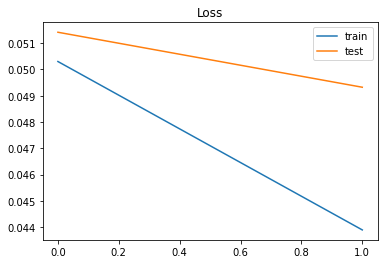

In [150]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

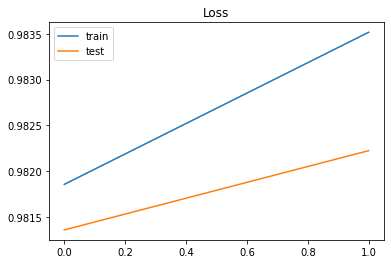

In [151]:
plt.title('Loss')
plt.plot(history.history['binary_accuracy'], label='train')
plt.plot(history.history['val_binary_accuracy'], label='test')
plt.legend()
plt.show();

In [136]:
test=pd.read_csv("./jigsaw-toxic-comment-classification-challenge/test.csv.zip")
test_lab = pd.read_csv("./jigsaw-toxic-comment-classification-challenge/test_labels.csv")

In [137]:
df_test = test.merge(test_lab, on = 'id')
df_test = df_test[df_test['toxic'] != -1]
y_test = df_test[list_classes].to_numpy()

In [138]:
df_test['comment_text'] = df_test['comment_text'].apply(clean_text)
X_test = tokenizer.texts_to_sequences(df_test["comment_text"].values)
X_test = sequence.pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)

In [142]:
y_test.shape

(63978, 6)

In [152]:
rnn_model.evaluate(X_test,y_test)

2000/2000 [==============================] - 22s 11ms/step - loss: 0.0732 - binary_accuracy: 0.9698


[0.0731869637966156, 0.96981281042099]

In [155]:
rnn_model.save_weights("mamodel2")

In [154]:
%pip install gensim

     |████████████████████████████████| 24.2 MB 12.8 MB/s eta 0:00:01
     |████████████████████████████████| 119 kB 16.4 MB/s eta 0:00:01
  Created wheel for smart-open: filename=smart_open-4.2.0-py3-none-any.whl size=109632 sha256=9b180c4fde8e3984f2612ecf6f132f0ccd3cf3cc107fa2a7f148cc09169894a6
  Stored in directory: /Users/Ryan/Library/Caches/pip/wheels/24/f6/ea/70a0761bdfaeacff66662751fe71920e25c4c43d97098a3886
Successfully built smart-open
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [156]:
import gensim

In [161]:
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [205]:
dic=tokenizer.word_index

In [216]:
maxi=0
for i in range(len(X)):
    if X[i].max()>maxi:
        maxi=X[i].max()
print(maxi)

9999


In [247]:
weights=[np.zeros((300,)).tolist()]
for i,word in enumerate(dic.keys()):
    if i>(MAX_NB_WORDS-2):
        break
    try:
        weights.append(model[word].tolist())
    except KeyError:
        weights.append(np.zeros((300,)).tolist())
    

In [248]:
len(weights)

10000

In [243]:
rnn_model.layers[0].get_weights()[0].shape

(10000, 100)

In [249]:
np.array(weights).shape

(10000, 300)